# UPI Fraud Risk Prediction using Artificial Neural Network (ANN)

## Deep Learning for Managers  
Group No: ___  

### Objective
To develop an ANN-based fraud risk prediction model using UPI transaction trends (2018–2024).

### Business Relevance
As UPI transaction volume and value grow exponentially, fraud exposure increases. This model helps fintech firms identify high-risk periods and implement proactive fraud prevention policies.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [3]:
import os
print(os.listdir())


['.ipynb_checkpoints', 'Product-Statistics-UPI-Product-statistics-upi-2018-19-Monthly.xlsx', 'Product-Statistics-UPI-Product-statistics-upi-2019-20-Monthly.xlsx', 'Product-Statistics-UPI-Product-statistics-upi-2020-21-Monthly.xlsx', 'Product-Statistics-UPI-Product-statistics-upi-2021-22-Monthly.xlsx', 'Product-Statistics-UPI-Product-statistics-upi-2022-23-Monthly.xlsx', 'Product-Statistics-UPI-Product-statistics-upi-2023-24-Monthly.xlsx', 'UPI_Fraud_ANN_GroupX.ipynb.ipynb']


In [2]:
import pandas as pd
import os

files = [f for f in os.listdir() if f.endswith(".xlsx")]

for file in files:
    print("\nFile:", file)
    df = pd.read_excel(file, engine='openpyxl')
    print(df.columns)
    break   # just inspect first file



File: Product-Statistics-UPI-Product-statistics-upi-2018-19-Monthly.xlsx
Index(['Month', 'No. of Banks live on UPI', 'Volume (In Mn.)',
       'Value (In Cr.)'],
      dtype='str')


In [3]:
import pandas as pd
import os

files = [f for f in os.listdir() if f.endswith(".xlsx")]
print("Files detected:", files)

all_data = []

for file in files:
    df = pd.read_excel(file, engine='openpyxl')
    
    # Select correct columns
    df = df[['Month', 'Volume (In Mn.)', 'Value (In Cr.)']]
    
    # Extract year from filename
    year = file.split('-')[-2]   # 2018-19 etc.
    df['Year_Label'] = year
    
    all_data.append(df)

# Combine all years
upi_data = pd.concat(all_data, ignore_index=True)

# Rename columns
upi_data.columns = ['Month', 'Volume_Million', 'Value_Crore', 'Year_Label']

# Clean numeric values
upi_data['Volume_Million'] = (
    upi_data['Volume_Million']
    .astype(str)
    .str.replace(',', '', regex=False)
    .astype(float)
)

upi_data['Value_Crore'] = (
    upi_data['Value_Crore']
    .astype(str)
    .str.replace(',', '', regex=False)
    .astype(float)
)

# Extract numeric year
upi_data['Year'] = upi_data['Year_Label'].str[:4].astype(int)

# Convert month to numeric
month_map = {
    'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,
    'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12
}

upi_data['Month_Num'] = upi_data['Month'].map(month_map)

# Sort chronologically
upi_data = upi_data.sort_values(['Year','Month_Num']).reset_index(drop=True)

print("\nFinal dataset shape:", upi_data.shape)
upi_data.head()


Files detected: ['Product-Statistics-UPI-Product-statistics-upi-2018-19-Monthly.xlsx', 'Product-Statistics-UPI-Product-statistics-upi-2019-20-Monthly.xlsx', 'Product-Statistics-UPI-Product-statistics-upi-2020-21-Monthly.xlsx', 'Product-Statistics-UPI-Product-statistics-upi-2021-22-Monthly.xlsx', 'Product-Statistics-UPI-Product-statistics-upi-2022-23-Monthly.xlsx', 'Product-Statistics-UPI-Product-statistics-upi-2023-24-Monthly.xlsx']

Final dataset shape: (72, 6)


,Month,Volume_Million,Value_Crore,Year_Label,Year,Month_Num
0,March-2019,799.54,133460.72,19,19,NaN
1,February-2019,674.19,106737.12,19,19,NaN
2,January-2019,672.75,109932.43,19,19,NaN
3,December-2018,620.17,102594.82,19,19,NaN
4,November-2018,524.94,82232.21,19,19,NaN


In [4]:
print(upi_data[['Year', 'Month']].head(15))


    Year           Month
0     19      March-2019
1     19   February-2019
2     19    January-2019
3     19   December-2018
4     19   November-2018
5     19    October-2018
6     19  September-2018
7     19     August-2018
8     19       July-2018
9     19       June-2018
10    19        May-2018
11    19      April-2018
12    20      March-2020
13    20   February-2020
14    20    January-2020


In [5]:
# Convert Month column directly to datetime
upi_data['Date'] = pd.to_datetime(upi_data['Month'], format='%B-%Y')

# Extract correct year and month number
upi_data['Year'] = upi_data['Date'].dt.year
upi_data['Month_Num'] = upi_data['Date'].dt.month

# Sort properly
upi_data = upi_data.sort_values('Date').reset_index(drop=True)

# Check result
upi_data[['Date','Year']].head(10)


,Date,Year
0,2018-04-01,2018
1,2018-05-01,2018
2,2018-06-01,2018
3,2018-07-01,2018
4,2018-08-01,2018
5,2018-09-01,2018
6,2018-10-01,2018
7,2018-11-01,2018
8,2018-12-01,2018
9,2019-01-01,2019


In [6]:
# Create growth features
upi_data['Volume_Growth'] = upi_data['Volume_Million'].pct_change()
upi_data['Value_Growth'] = upi_data['Value_Crore'].pct_change()

# Drop first row (NaN from pct_change)
upi_data = upi_data.dropna().reset_index(drop=True)

upi_data[['Date','Volume_Growth','Value_Growth']].head()


,Date,Volume_Growth,Value_Growth
0,2018-05-01,-0.003157,0.231911
1,2018-06-01,0.300243,0.226670
2,2018-07-01,0.111134,0.269606
3,2018-08-01,0.139799,0.045698
4,2018-09-01,0.300782,0.103724


In [7]:
# Define high growth threshold (top 25%)
threshold = upi_data['Volume_Growth'].quantile(0.75)

upi_data['Fraud_Risk'] = (upi_data['Volume_Growth'] > threshold).astype(int)

print(upi_data['Fraud_Risk'].value_counts())


Fraud_Risk
0    53
1    18
Name: count, dtype: int64


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = ['Volume_Million','Value_Crore','Volume_Growth','Value_Growth']

X = upi_data[features]
y = upi_data['Fraud_Risk']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 56
Testing samples: 15


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 705 (2.75 KB)

 Trainable params: 705 (2.75 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=8,
    validation_split=0.2,
    verbose=1
)


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.7500 - loss: 0.5850 - val_accuracy: 0.7500 - val_loss: 0.5523
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.5450 - val_accuracy: 0.7500 - val_loss: 0.5120
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.5084 - val_accuracy: 0.7500 - val_loss: 0.4757
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.4744 - val_accuracy: 0.7500 - val_loss: 0.4459
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7500 - loss: 0.4507 - val_accuracy: 0.7500 - val_loss: 0.4190
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7727 - loss: 0.4269 - val_accuracy: 0.8333 - val_loss: 0.3969
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8409 - loss: 0.4074 - val_accuracy: 0.9167 - val_loss: 0.3790
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8409 - loss: 0.3900 - val_accuracy: 0.9167 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         4

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



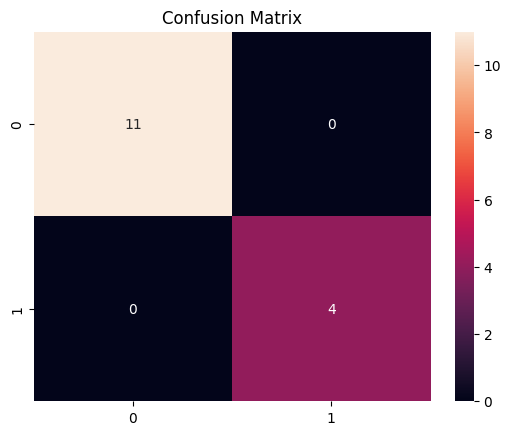

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions = (model.predict(X_test) > 0.5).astype(int)

print(classification_report(y_test, predictions))

cm = confusion_matrix(y_test, predictions)

sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


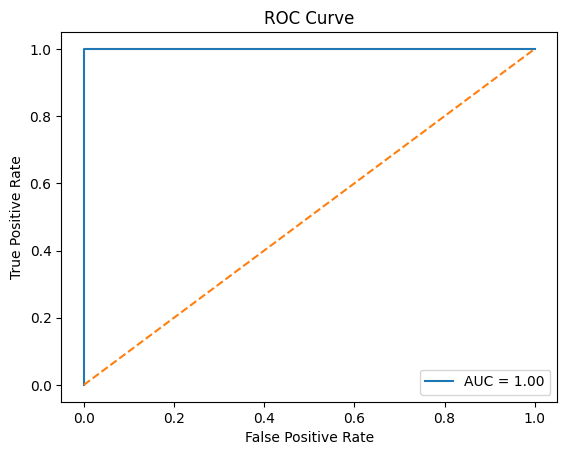

AUC Score: 1.0


In [13]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get probability predictions
y_prob = model.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

print("AUC Score:", auc_score)
